In [ ]:
%pip install --upgrade networkx
%pip install umap-learn

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import networkx as nx
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    GPT2Config
)

from transformers import (
    GPTNeoForCausalLM,
    GPTNeoConfig,
    GPT2Tokenizer
)
import umap.umap_ as umap

import glob
import os
from PIL import Image


In [2]:
# Enable hidden states 


model_id = "EleutherAI/gpt-neo-1.3B"
cache_dir = "Z:\\LLMCache"

config = GPTNeoConfig.from_pretrained(model_id, output_hidden_states=True)
model = GPTNeoForCausalLM.from_pretrained(model_id, config=config, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_id)

model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj):

In [3]:
input_texts = [
    "Gardening is more than just a pastime; it’s a nurturing process that connects us with nature and sparks creativity. Each seed planted represents a small act of hope, carrying the promise of vibrant blossoms or fresh vegetables. Tending to soil, watering regularly, and removing weeds teaches patience and dedication. The rewards are manifold: from the soothing effect of working outdoors to the satisfaction of watching tiny sprouts grow into healthy plants. Gardening also reduces stress and encourages mindfulness. It’s not merely about tending flowers but also fostering one’s sense of purpose, making it a truly enriching and satisfying hobby.",

    "Modern architecture pushes the boundaries of design through innovative materials and cutting-edge construction methods. Sleek lines, open layouts, and sustainable features are hallmarks of these contemporary structures. Steel, glass, and concrete often dominate the aesthetic, giving rise to buildings that seamlessly merge function with striking form. From towering skyscrapers in bustling cities to eco-friendly homes nestled in quiet suburbs, modern architecture reflects the ever-evolving needs of our society. Advanced technologies like 3D printing and virtual reality also shape the field, allowing architects to experiment with bold ideas. Ultimately, modern architecture redefines how we experience and inhabit the spaces we call home.",

    "Classical literature stands as a timeless testament to human creativity, illuminating universal truths across centuries. Works by authors like Homer, Shakespeare, and Tolstoy transport readers into distant realms and eras while grappling with themes such as love, power, and morality. These texts challenge us to question our assumptions, confront human frailties, and celebrate resilience. Often written in elevated language and complex structures, they encourage deep reading and reflection. Though centuries may separate modern audiences from these authors, their words resonate with emotional honesty and vibrant storytelling. Classical literature thus endures as a cornerstone of education, culture, and profound intellectual engagement.",

    "Wildlife conservation is crucial for maintaining the balance of ecosystems worldwide. Every species, from the smallest insects to majestic whales, plays a unique role in the intricate web of life. When one species diminishes or disappears, it affects countless others, disrupting food chains and natural processes. Conservation efforts focus on habitat protection, anti-poaching regulations, and education initiatives that highlight the importance of biodiversity. Protecting endangered species not only preserves natural heritage but also ensures resources like clean water and fertile soil for future generations. Through collective action and responsible stewardship, we can safeguard our planet’s incredible array of life forms.",

    "Ancient mythology offers rich narratives that reveal the values, fears, and aspirations of early civilizations. Myths about gods, heroes, and creatures were deeply intertwined with daily life, often explaining natural phenomena or teaching moral lessons. Greek tales of Zeus and Athena, Norse sagas of Thor and Odin, and Egyptian stories of Ra and Anubis continue to captivate modern audiences. These stories served as both religious texts and cultural touchstones, shaping everything from political power structures to artistic expression. Despite their fantastical elements, myths hold enduring relevance, emphasizing universal themes such as love, betrayal, and the relentless pursuit of knowledge.",

    "Digital art has revolutionized the creative landscape by merging traditional artistic expression with modern technology. Artists can now sketch, paint, and sculpt in virtual environments using advanced software and tools. This flexibility opens up endless possibilities for experimentation, as layers can be added or removed, and color palettes adjusted instantly. Social media platforms provide opportunities for digital artists to share their work globally, garnering feedback and inspiration from diverse audiences. Moreover, new mediums like NFTs have emerged, offering novel ways to buy and sell digital pieces. As technology evolves, digital art continues to expand, reshaping our understanding of creativity.",

    "Personal finance revolves around budgeting, saving, and investing wisely to secure one’s financial well-being. Planning starts with a clear overview of monthly income and expenses, which helps identify unnecessary costs and prioritize essential spending. Building an emergency fund is vital to handle unexpected events like medical bills or car repairs without accruing debt. Investing strategies can vary—some prefer stocks, while others lean toward real estate or mutual funds. It’s also important to manage credit responsibly, aiming to maintain a strong credit score. Good personal finance habits cultivate stability and peace of mind, helping people reach both short-term and long-term goals.",

    "World cuisine is a vibrant tapestry of flavors, reflecting the history, geography, and cultural traditions of diverse regions. From the aromatic spices of Indian curries to the comforting pasta dishes of Italian homes, each culinary style tells a story of local ingredients and techniques passed down through generations. Street food in Southeast Asia, for example, combines sweet, salty, and spicy elements in bold combinations that awaken the palate. Regional specialties often highlight fresh, seasonal produce, celebrating the bounty of land and sea. As cultures interact and globalize, fusion dishes emerge, blending time-honored recipes with modern twists to create mouthwatering new experiences.",
]
#    "Climate change poses a significant challenge to life on Earth, affecting everything from weather patterns to the stability of ecosystems. Greenhouse gases trap heat in the atmosphere, leading to melting ice caps, rising sea levels, and increasingly unpredictable storms. As temperatures shift, wildlife habitats shrink or relocate, and humans face disrupted agriculture. Addressing climate change requires coordinated efforts: reducing carbon emissions, adopting renewable energy sources, and promoting sustainable consumption habits. Governments, businesses, and individuals all share responsibility in turning the tide. By embracing environmental stewardship and innovative solutions, we can strive to preserve our planet for generations to come.",

#    "Travel photography is a vibrant medium that captures the essence of diverse cultures, landscapes, and experiences. From bustling urban markets to serene mountain vistas, each image tells a unique story. Skilled photographers learn to adapt to varying light conditions, from golden sunrise rays to the stark contrasts of midday sun. Travel photos often reveal the spirit of a location, highlighting local architecture, street life, and natural wonders. The process encourages deeper engagement with the environment and people, fostering understanding and empathy. Sharing these images invites others to explore unknown destinations, ultimately broadening horizons and sparking wanderlust in those who see them."
#]

input_texts_token_lengths = [
    len(tokenizer.encode(paragraph))
    for paragraph in input_texts
]

print("Token lengths per paragraph:", input_texts_token_lengths)
print("Cumulative sums:", np.cumsum(input_texts_token_lengths))


Token lengths per paragraph: [128, 129, 123, 123, 123, 121, 130, 128]
Cumulative sums: [ 128  257  380  503  626  747  877 1005]


In [7]:
input_text = " ".join(input_texts)
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

print(inputs["input_ids"].size())

with torch.no_grad():
    outputs = model(**inputs)
all_hidden_states = outputs.hidden_states # 13 states

seq_len = all_hidden_states[1].size()[1]
token_indices = np.arange(seq_len)


# cumulative sums
cumulative_lengths = np.cumsum(input_texts_token_lengths)

seq_len = all_hidden_states[0].size(1)   
token_indices = np.arange(seq_len) 

# np.searchsorted can assign each token index to the correct paragraph
group_ids = np.searchsorted(cumulative_lengths, token_indices, side="right")

num_groups = group_ids.max() + 1 

base_colors_hex = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#bcbd22",  # olive
    #"#46f0f0",  # cyan
    #"#f032e6",  # magenta
]

point_colors = [base_colors_hex[g] for g in group_ids]

cmap = plt.cm.get_cmap("Set1", num_groups)


torch.Size([1, 1003])


C:\Users\Danie\AppData\Local\Temp\ipykernel_27268\490404706.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set1", num_groups)


In [8]:

base_colors_rgb = [mcolors.to_rgb(h) for h in base_colors_hex]

def get_group_fractions(group_ids):
    fractions = np.zeros_like(group_ids, dtype=float)
    unique_groups = np.unique(group_ids)
    
    for g in unique_groups:
        g_indices = np.where(group_ids == g)[0]
        if len(g_indices) <= 1:
            fractions[g_indices] = 0.0
            continue
        local_positions = np.arange(len(g_indices))
        local_fractions = local_positions / (len(g_indices) - 1)
        fractions[g_indices] = local_fractions
    return fractions

def blend_color_and_alpha(base_color, frac, 
                          start_alpha=0.2, end_alpha=1.0, 
                          light_factor=0.5):
    alpha = start_alpha + frac * (end_alpha - start_alpha)
    
    r0, g0, b0 = base_color
    white_blend = light_factor * (1.0 - frac)
    r = (1.0 * white_blend) + r0 * (1.0 - white_blend)
    g = (1.0 * white_blend) + g0 * (1.0 - white_blend)
    b = (1.0 * white_blend) + b0 * (1.0 - white_blend)
    
    return (r, g, b, alpha)

def create_final_colors(group_ids, base_colors_rgb,
                        start_alpha=0.2, end_alpha=1.0, 
                        light_factor=0.5):
    fractions = get_group_fractions(group_ids)
    final_colors = np.zeros((len(group_ids), 4), dtype=float)
    
    for i, g in enumerate(group_ids):
        base_color = base_colors_rgb[g % len(base_colors_rgb)]
        frac       = fractions[i]
        rgba       = blend_color_and_alpha(base_color, frac,
                                           start_alpha=start_alpha,
                                           end_alpha=end_alpha,
                                           light_factor=light_factor)
        final_colors[i] = rgba
    return final_colors



input_text = " ".join(input_texts)
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)
all_hidden_states = outputs.hidden_states # 13 states

all_hidden_states = outputs.hidden_states  # For instance
for layer_nr, layer_state in enumerate(all_hidden_states):
    # shape: [batch_size, seq_len, hidden_size]
    layer = layer_state.cpu().squeeze()  # -> [seq_len, hidden_size]
    
    reducer = umap.UMAP(
        n_neighbors=5,
        n_components=2,
        metric='euclidean',
        repulsion_strength=2,
        random_state=42
    )
    umap_result = reducer.fit_transform(layer)
    
    final_colors = create_final_colors(
        group_ids=group_ids, 
        base_colors_rgb=base_colors_rgb,
        start_alpha=0.2,  
        end_alpha=1.0,     
        light_factor=0.5   
    )
    
    plt.figure(figsize=(10, 8))
    plt.scatter(umap_result[:, 0], umap_result[:, 1],
                c=final_colors, s=20)
    
    plt.title(f"GPT Neo 1.3B (UMAP 2D Projection) – Layer: {layer_nr}")
    plt.axis("off")
    plt.savefig(f"images/8doc_split_gptNeo1.3B/umap_layer{layer_nr}.png",
                dpi=150, bbox_inches='tight')
    plt.close()


c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding 

In [22]:

image_folder = "images/8doc_split_gptNeo1.3B/"
png_files = glob.glob(os.path.join(image_folder, "umap_layer*.png"))

# Sort by the numeric part after "umap_layer" and before ".png"
png_files = sorted(png_files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0].replace("umap_layer", "")))

frames = []
for file in png_files:
    print(file)
    frame = Image.open(file)
    frames.append(frame)

if frames:
    frames[0].save(
        "gptneo1.3B.gif",
        save_all=True,
        append_images=frames[1:], 
        duration=500,  
        loop=1
    )
    print("GIF successfully saved as gptneo1.3B.gif")
else:
    print("No images found in the folder!")

images/8doc_split_gptNeo1.3B\umap_layer0.png
images/8doc_split_gptNeo1.3B\umap_layer1.png
images/8doc_split_gptNeo1.3B\umap_layer2.png
images/8doc_split_gptNeo1.3B\umap_layer3.png
images/8doc_split_gptNeo1.3B\umap_layer4.png
images/8doc_split_gptNeo1.3B\umap_layer5.png
images/8doc_split_gptNeo1.3B\umap_layer6.png
images/8doc_split_gptNeo1.3B\umap_layer7.png
images/8doc_split_gptNeo1.3B\umap_layer8.png
images/8doc_split_gptNeo1.3B\umap_layer9.png
images/8doc_split_gptNeo1.3B\umap_layer10.png
images/8doc_split_gptNeo1.3B\umap_layer11.png
images/8doc_split_gptNeo1.3B\umap_layer12.png
images/8doc_split_gptNeo1.3B\umap_layer13.png
images/8doc_split_gptNeo1.3B\umap_layer14.png
images/8doc_split_gptNeo1.3B\umap_layer15.png
images/8doc_split_gptNeo1.3B\umap_layer16.png
images/8doc_split_gptNeo1.3B\umap_layer17.png
images/8doc_split_gptNeo1.3B\umap_layer18.png
images/8doc_split_gptNeo1.3B\umap_layer19.png
images/8doc_split_gptNeo1.3B\umap_layer20.png
images/8doc_split_gptNeo1.3B\umap_layer21.pn

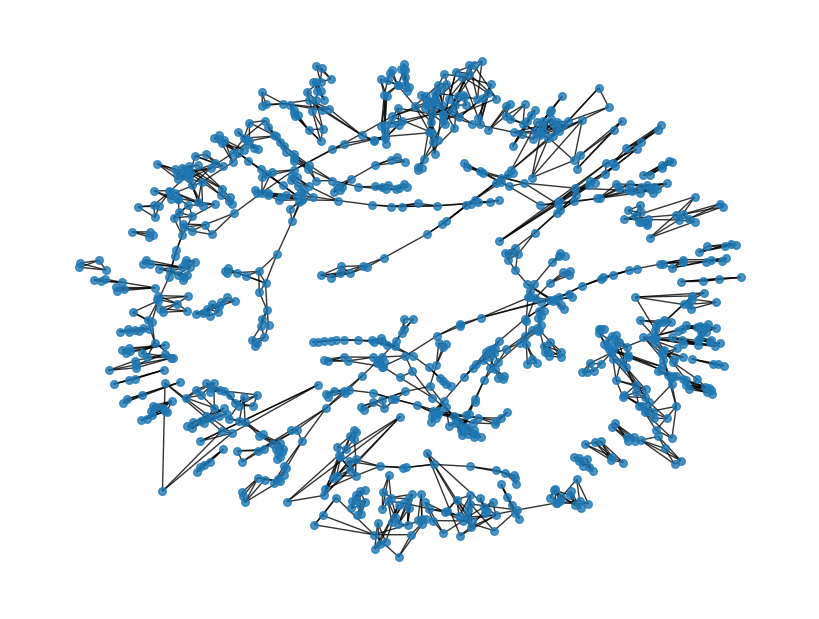

In [18]:
k = 4
neighbors = NearestNeighbors(n_neighbors=k, metric="euclidean")
neighbors.fit(umap_result)
knn_graph = neighbors.kneighbors_graph(umap_result, mode='distance')

G = nx.Graph()
coo_mat = knn_graph.tocoo()
for i, j, dist in zip(coo_mat.row, coo_mat.col, coo_mat.data):
    if i != j:
        G.add_edge(i, j, weight=dist)

# 3) Choose a layout and draw
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos=pos, node_size=30, alpha=0.8, with_labels=False)
plt.show()

In [19]:
nx.write_gexf(G, "biglast.gexf")
